# Introduction

This notebook shows a very simple pipeline to explore a phone sensors dataset ("Physical Activity Recognition Dataset Using Smartphone Sensors") from http://ps.ewi.utwente.nl/Datasets.php, and develop and test a ML algorithm to predict the type of physical activity the user is engaging in.

### Results
We claim an ~84% accuracy with a properly trained random forest *multiclass* and *multioutput* classifier.


## Imports: with hindsight of course...

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.multioutput import MultiOutputClassifier

# Data Exploration

In [2]:
!ls Activity_Recognition_DataSet

Arm.xlsx    Belt.xlsx   Pocket.xlsx Readme.txt  Wrist.xlsx


In [2]:
df_arm=pd.read_excel("Activity_Recognition_DataSet/Arm.xlsx")
df_pocket=pd.read_excel("Activity_Recognition_DataSet/Pocket.xlsx")
df_wrist=pd.read_excel("Activity_Recognition_DataSet/Wrist.xlsx")
df_belt=pd.read_excel("Activity_Recognition_DataSet/Belt.xlsx")

Let me report here some of the readme content

## 1 Data Collection Procedure 

We used four Samsung Galaxy S2 smartphones in our experiments for data collection. Using these smartphones, we collected data for six different physical activities. They are walking, running, sitting, standing, walking upstairs and downstairs. We asked four participants to perform these six activities for a few minutes. As these are repetitive activities, so the amount of time for each activity was kept between 3-5 minutes per participant which gave us enough examples for our evaluations. The activities were carried out indoor in one of our university buildings. For walking, and running, the department's corridor was used. For sitting activity, participants’ offices were used when they were using their computers. For standing activity, coffee area was used where some participants stood for few minutes while involved in a conversation with others. For walking upstairs and downstairs, 5-floor stairs were used. It is important to mention that these stairs had short walks at each floor for switching between stairs (2-3 steps) but there were only four such switches in the whole walking upstairs and downstairs activities. We could not find one single continuous stair from first till 5th floor. Each of these participants was provided with four smartphones on four body positions: right jeans pocket, belt, arm, and wrist. The data was recorded for all four positions at the same time for each activity. All the four participants were male, between the age of 25 and 30. They signed a consent form before taking part in the activities

In [4]:
df_arm.head()

,Time_Stamp,Ax,Ay,Az,Gx,Gy,Gz,Mx,My,Mz,Activity_Label
0,1364396345335,-17.365944,19.517958,0.885323,-0.121868,2.177429,1.535715,18.300000,-44.160000,8.639999,Downstairs
1,1364396345354,-9.684067,13.933616,1.157730,-0.053145,-1.751656,1.254106,17.279999,-44.160000,9.179999,Downstairs
2,1364396345375,-4.045243,7.709117,-1.266692,-0.596510,-3.471852,1.176526,16.500000,-44.399998,9.360000,Downstairs
3,1364396345394,-1.770645,5.788648,-0.735499,-0.867734,-2.983771,0.893696,15.900000,-44.520000,9.360000,Downstairs
4,1364396345414,2.819412,3.963521,0.599295,-0.541227,-2.662762,0.328645,15.000000,-44.700000,9.240000,Downstairs


ok let's see the descriptions

In [15]:
df_arm.describe()

,Time_Stamp,Ax,Ay,Az,Gx,Gy,Gz,Mx,My,Mz
count,1.606550e+05,160655.000000,160655.000000,160655.000000,160655.000000,160655.000000,160655.000000,160655.000000,160655.000000,160655.000000
mean,1.364371e+12,-0.275081,8.763833,2.281637,0.006953,0.035258,-0.014379,0.291451,-39.890499,-9.432653
std,4.265402e+07,4.576472,4.180374,2.368637,0.501906,1.292655,1.260051,17.396151,7.601236,14.301760
min,1.364300e+12,-19.517958,-7.709117,-14.873420,-3.382361,-6.743647,-7.708508,-46.739998,-80.460000,-46.920000
25%,1.364310e+12,-1.906849,7.055340,0.885323,-0.175624,-0.327424,-0.440281,-13.259999,-45.899998,-21.180000
50%,1.364398e+12,0.122583,8.798744,2.138395,-0.000305,-0.000305,0.000916,0.720000,-40.500000,-12.059999
75%,1.364400e+12,1.838747,10.065437,3.854558,0.181732,0.370490,0.294132,11.639999,-34.559998,2.220000
max,1.364403e+12,19.531578,19.599680,19.381754,3.577227,7.074431,8.998656,47.940000,23.400000,41.520000


## Comments:

Acceleration seems to be small on average on the arm unit's x axis and large on y and z. This would make sense if the sensor was mounted on the arm with the y axis, the most mobile, being perpendicular to the arm to the front of the person, the x axis being along the arm and the z axis perpendicular to the arm sticking sideways away from the person.

If this is true then the largest average value of the angular momentum should be around the y axis (rotation of the arm out and sideways) and practically vanishing around the x axis (a healthy arm can't spin around itself), which is also true!

Similar sanity checks shoud be considered for all sensors but for sake of time I'll put that off.


### 4 participants

I'm not sure how to distinguish between different participants, this might be an important confounding factor? Random cross validation might fail to recognize overfitting to the single user, i.e. a good performance might depend on the fact that the validation samples all belong to users that the model has already seen in training.

### time stamps

Upon further investigation, they are not denoting absolute time. This a bit annoying, as time-series features would require taking care of all the discontinuities. The sampling is more or less done every 0.2 seconds. Definitely leave them out of the features.

In [396]:
#let's create numerical codes for the activity labels
act_dict={'Walking':0,'Running':1,'Downstairs':2,'Upstairs':3,'Standing':4,'Sitting':5}
for df in [df_wrist,df_arm,df_belt,df_pocket]:
    df["Activity_Label_num"]=df["Activity_Label"].apply(lambda x:act_dict[x])

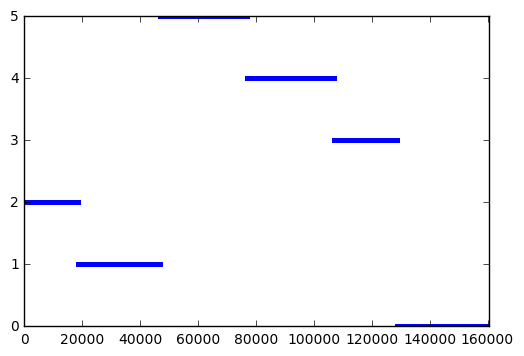

In [416]:
df_arm["Activity_Label_num"].plot(style='.')

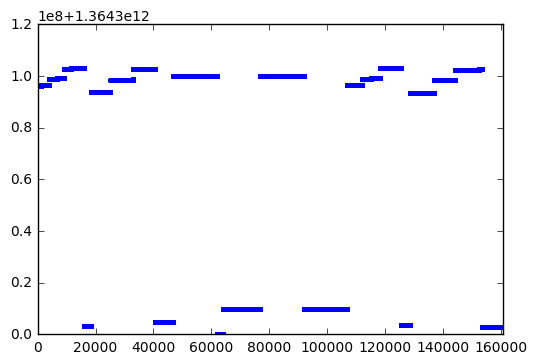

In [389]:
df_arm["Time_Stamp"].plot(style='.')

In [433]:
index_low_ts,index_high_ts=[],[]
index_low_ts_cum,index_high_ts_cum=[],[]
len_df_old=0
for df in [df_wrist,df_arm,df_belt,df_pocket]:
    index_low_ts+=[df[df["Time_Stamp"]<1364360000000].index]
    index_high_ts+=[df[df["Time_Stamp"]>=1364360000000].index]
    index_low_ts_cum+=[df[df["Time_Stamp"]<1364360000000].index+len_df_old]
    index_high_ts_cum+=[df[df["Time_Stamp"]>=1364360000000].index+len_df_old]
    len_df_old=len(df)

# There you go!
It is actually possible to distinguish different participants by looking at discontinuities in the time stamp series.

This means we should split the testing set from training keeping different participants separate to see how this will generalize to new unrelated users.

# Feature engineering

Applying some domain knowledge of physics here might be a good idea.
- Extracting the magnitude of the acc/ang mom/magnetic field vectors might be useful, as this might remove some noise vs. using the components and create a more meaningful feature to split on.
- Smoothing out the various feature over a ~1 second window might also help 
- Using short-time FFT power analysis might yield precious info about periodicity of motions

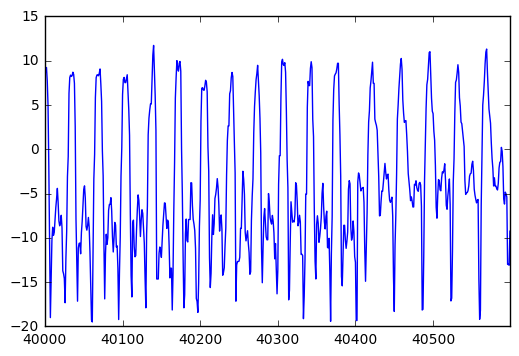

In [445]:
#example: Ax is ~periodic
df_arm["Ax"][40000:40600].plot()

In [446]:
# this function extract the local period for every row
def maxfft(el,col,df):
    freq=[]
    for n in {20,30,40,50}:
        start=max(0,el-n//2)
        end=min(len(df)-1,el+n//2)
        nn=end-start
        freq+=[nn/(1+np.argmax(np.abs(np.fft.fft(df[start:end][col]))[1:(nn//2)]))]
    return np.median(freq)

In [333]:
for df in [df_wrist,df_arm,df_belt,df_pocket]:
    df["A"]=np.sqrt(df["Ax"]**2+df["Ay"]**2+df["Az"]**2)
    df["A_smooth"]=np.sqrt(df["Ax"]**2+df["Ay"]**2+df["Az"]**2).rolling(window=5,min_periods=1).mean()
    df["G"]=np.sqrt(df["Gx"]**2+df["Gy"]**2+df["Gz"]**2)
    df["M"]=np.sqrt(df["Mx"]**2+df["My"]**2+df["Mz"]**2)
    df["x_M"]=df["Mx"]/df["M"]
    df["y_M"]=df["My"]/df["M"]
    df["z_M"]=df["Mz"]/df["M"]
    df["period"]=pd.Series([maxfft(i,"A_smooth",df) for i in range(len(df))]).rolling(window=3,min_periods=1).mean()

In [398]:
for df in [df_wrist,df_arm,df_belt,df_pocket]:
    for col in ["Ax","Ay","Az","Gx","Gy","Gz","G"]:
        df[col+"_smooth"]=df[col].rolling(window=5,min_periods=1).mean()

In [409]:
for df in [df_wrist,df_arm,df_belt,df_pocket]:
    for col in ["x_M","y_M","z_M"]:
        df[col+"_diff"]=df[col].diff().fillna(0.)

In [411]:
names=["wrist","arm","belt","pocket"]
for i,df in enumerate([df_wrist,df_arm,df_belt,df_pocket]):
    df[["Ax","Ay","Az","A","Gx","Gy","Gz","G","Ax_smooth","Ay_smooth","Az_smooth","A_smooth","Gx_smooth","Gy_smooth","Gz_smooth","G_smooth","x_M","y_M","z_M","x_M_diff","y_M_diff","z_M_diff","M","period","Activity_Label","Activity_Label_num",]].to_csv('Activity_Recognition_DataSet/'+names[i]+'.csv')

# Feature selection: magnetic field

The magnetic field features might be overfit-prone ones. The reason is that it is physically unreasonable that the instantaneous components of M should classify a physical activity. That fact plus the fact that they vary quite slowly in time makes it possible for my algorithm to memorize similar datapoints in training and recognize them in testing, producing unrealistic results. Rather, they might be very useful at telling how the user's orientation in space is changing, because the orientation of the external magnetic field is more or less always the same. So essentially these features would act like a *compass*. This would require though differencing the time series instead, as this would tell us how the positioning of the person's body limb is changing over time w.r.t. the ground, which is important information indeed. Also pay attention to the fact that not always is the magnetic field registered by the sensor attributable to the Earth's one, as it is way too strong.

So I'll try both differencing and leaving the mag field out. The second option will reveal to be the better.

### Let's create the data sets, train, tune, and all that jazz

Using the original features minus mag field plus the magnitudes of A and G and the period

In [350]:
x,y=dataprep(["Ax","Ay","Az","A","Gx","Gy","Gz","G","period"])

In [351]:
x_train,x_val,x_test,y_train,y_val,y_test,x_trainval,y_trainval=test_val_splitter(x,y)

In [352]:
aa=validator(x_train,x_val,y_train,y_val,n_estimators=10,max_depth=5)

Average validation accuracy for the activity classification task 0.682 +- 0.003
Average validation accuracy for the location classification task 0.860 +- 0.002


In [353]:
aa=validator(x_train,x_val,y_train,y_val,n_estimators=10,max_depth=10)

Average validation accuracy for the activity classification task 0.797 +- 0.002
Average validation accuracy for the location classification task 0.937 +- 0.001


In [354]:
aa=validator(x_train,x_val,y_train,y_val,n_estimators=10,max_depth=15)

Average validation accuracy for the activity classification task 0.870 +- 0.003
Average validation accuracy for the location classification task 0.960 +- 0.001


In [355]:
aa=validator(x_train,x_val,y_train,y_val,n_estimators=10,max_depth=20)

Average validation accuracy for the activity classification task 0.898 +- 0.001
Average validation accuracy for the location classification task 0.967 +- 0.001


In [356]:
aa=validator(x_train,x_val,y_train,y_val,n_estimators=10,max_depth=25)

Average validation accuracy for the activity classification task 0.906 +- 0.001
Average validation accuracy for the location classification task 0.968 +- 0.001


In [358]:
aa=validator(x_train,x_val,y_train,y_val,n_estimators=30,max_depth=25)

Average validation accuracy for the activity classification task 0.914 +- 0.001
Average validation accuracy for the location classification task 0.971 +- 0.001


In [360]:
bb=tester(x_trainval,x_test,y_trainval,y_test,n_estimators=30,max_depth=25)

Average test accuracy for the activity classification task 0.917 +- 0.000
Average test accuracy for the location classification task 0.972 +- 0.000


Using the smoothed original features minus mag field plus the period

In [399]:
x,y=dataprep(["Ax_smooth","Ay_smooth","Az_smooth","A_smooth","Gx_smooth","Gy_smooth","Gz_smooth","G_smooth","period"])

In [400]:
x_train,x_val,x_test,y_train,y_val,y_test,x_trainval,y_trainval=test_val_splitter(x,y)

In [401]:
aa=validator(x_train,x_val,y_train,y_val,n_estimators=10,max_depth=5)

Average validation accuracy for the activity classification task 0.697 +- 0.005
Average validation accuracy for the location classification task 0.902 +- 0.002


In [402]:
aa=validator(x_train,x_val,y_train,y_val,n_estimators=10,max_depth=10)

Average validation accuracy for the activity classification task 0.820 +- 0.004
Average validation accuracy for the location classification task 0.960 +- 0.001


In [403]:
aa=validator(x_train,x_val,y_train,y_val,n_estimators=30,max_depth=20)

Average validation accuracy for the activity classification task 0.934 +- 0.001
Average validation accuracy for the location classification task 0.983 +- 0.001


In [404]:
bb=tester(x_trainval,x_test,y_trainval,y_test,n_estimators=30,max_depth=20)

Average test accuracy for the activity classification task 0.934 +- 0.000
Average test accuracy for the location classification task 0.983 +- 0.000


Using the smoothed original features plus the period and replacing the mag field components with the differenced normalized components 

In [413]:
x,y=dataprep(["x_M_diff","y_M_diff","z_M_diff","Ax_smooth","Ay_smooth","Az_smooth","A_smooth","Gx_smooth","Gy_smooth","Gz_smooth","G_smooth","period"])

In [414]:
x_train,x_val,x_test,y_train,y_val,y_test,x_trainval,y_trainval=test_val_splitter(x,y)

In [415]:
aa=validator(x_train,x_val,y_train,y_val,n_estimators=10,max_depth=5)

Average validation accuracy for the activity classification task 0.674 +- 0.001
Average validation accuracy for the location classification task 0.902 +- 0.001


Using the smoothed original features minus mag field plus the period with test split on different users!

In [437]:
x,y=dataprep(["Ax_smooth","Ay_smooth","Az_smooth","A_smooth","Gx_smooth","Gy_smooth","Gz_smooth","G_smooth","period"])

In [441]:
x_train,x_val,x_test,y_train,y_val,y_test,x_trainval,y_trainval=test_val_splitter(x,y,diffus=True)

In [442]:
aa=validator(x_train,x_val,y_train,y_val,n_estimators=10,max_depth=10)

Average validation accuracy for the activity classification task 0.813 +- 0.003
Average validation accuracy for the location classification task 0.958 +- 0.001


In [443]:
bb=tester(x_trainval,x_test,y_trainval,y_test,n_estimators=10,max_depth=10)

Average test accuracy for the activity classification task 0.842 +- 0.000
Average test accuracy for the location classification task 0.914 +- 0.000


## conclusion
If I am using correctly the time stamps to separate different users, this particular test shows that I am not overfitting.

## some functions
defining here a more automated validation/testing pipeline, bear with me

In [440]:
def dataprep(cols):
    # cols lets you specify which features to keep in consideration
    x,y,y_loc=[],[],[]

    for i,df in enumerate([df_wrist,df_arm,df_belt,df_pocket]):
        #x is a list of numpy arrays containing the features, the first 4 arrays have each one the contents from one 
        #different location, the fifth array has all the 4 arrays concatenated together
        x+=[np.array(df[cols])]
        #y has the labels for the corresponding activities
        y+=[np.array(df["Activity_Label"])]
        #y_loc has the labels (4) for location
        y_loc+=[[i]*len(df)]

    x+=[np.concatenate(x)]
    y+=[np.array(list(zip(np.concatenate(y_loc),np.concatenate(y))))]
    return x,y

def test_val_splitter(x,y,test_size=0.2,n_splits=8,diffus=False):
    x_trainval,y_trainval=[],[]
    x_test,y_test=[],[]
    if diffus:
        for xx,yy,il,ih in zip(x[:-1],y[:-1],index_low_ts,index_high_ts):
            x_test+=[xx[il]]
            y_test+=[yy[il]]
            x_trainval+=[xx[ih]]
            y_trainval+=[yy[ih]]
        x_test+=[x[4][np.concatenate(index_low_ts_cum)]]
        y_test+=[y[4][np.concatenate(index_low_ts_cum)]]
        x_trainval+=[x[4][np.concatenate(index_high_ts_cum)]]
        y_trainval+=[y[4][np.concatenate(index_high_ts_cum)]]
    else:
        for xx,yy in zip(x,y):
            splittertemp = train_test_split(xx,yy,test_size=test_size)
            x_trainval+=[splittertemp[0]]
            x_test+=[splittertemp[1]]
            y_trainval+=[splittertemp[2]]
            y_test+=[splittertemp[3]]
        
    x_train,y_train=[],[]
    x_val,y_val=[],[]
    for x_trv,y_trv in zip(x_trainval,y_trainval):
        x_tr,y_tr=[],[]
        x_v,y_v=[],[]
        for train,val in KFold(n_splits=n_splits,shuffle=True).split(x_trv):
            x_tr+=[x_trv[train]]
            x_v+=[x_trv[val]]
            y_tr+=[y_trv[train]]
            y_v+=[y_trv[val]]
        x_train+=[x_tr]
        x_val+=[x_v]
        y_train+=[y_tr]
        y_val+=[y_v]
    return x_train,x_val,x_test,y_train,y_val,y_test,x_trainval,y_trainval

In [339]:
def validator(x_train,x_val,y_train,y_val,n_estimators=20,random_state=1, criterion='gini', max_depth=None,min_samples_split=2, min_samples_leaf=2, 
     min_weight_fraction_leaf=0.0,max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07,bootstrap=True, 
     oob_score=False, n_jobs=1, verbose=0, warm_start=False, class_weight=None):    
    scores_act=[]
    scores_loc=[]
    for i in range(8):
        model=RandomForestClassifier(n_estimators=n_estimators,random_state=random_state, criterion=criterion, 
                                     max_depth=max_depth, min_samples_split=min_samples_split,
                                     min_samples_leaf=min_samples_leaf, 
                                     min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features,
                                     max_leaf_nodes=max_leaf_nodes,min_impurity_split=min_impurity_split,
                                     bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, verbose=verbose, 
                                     warm_start=warm_start,class_weight=class_weight)
        multi_model = MultiOutputClassifier(model, n_jobs=-1)
        multi_model.fit(x_train[4][i],y_train[4][i])
        scores_act+=[len(y_val[4][i][y_val[4][i][:,1]==multi_model.predict(x_val[4][i])[:,1]])/len(y_val[4][i])]
        scores_loc+=[len(y_val[4][i][y_val[4][i][:,0]==multi_model.predict(x_val[4][i])[:,0]])/len(y_val[4][i])]
    print("Average validation accuracy for the activity classification task","%.3f" %np.mean(scores_act),"+-",
          "%.3f" %np.std(scores_act))
    print("Average validation accuracy for the location classification task","%.3f" %np.mean(scores_loc),"+-",
          "%.3f" %np.std(scores_loc))
    return np.mean(scores_act),np.std(scores_act),np.mean(scores_loc),np.std(scores_loc)

In [340]:
def tester(x_trainval,x_test,y_trainval,y_test,n_estimators=20,random_state=1, criterion='gini', max_depth=None,min_samples_split=2, min_samples_leaf=2, 
     min_weight_fraction_leaf=0.0,max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07,bootstrap=True, 
     oob_score=False, n_jobs=1, verbose=0, warm_start=False, class_weight=None):    
    scores_act=[]
    scores_loc=[]
    model=RandomForestClassifier(n_estimators=n_estimators,random_state=random_state, criterion=criterion, 
                                max_depth=max_depth, min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf, 
                                min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features,
                                max_leaf_nodes=max_leaf_nodes,min_impurity_split=min_impurity_split,
                                bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, verbose=verbose, 
                                warm_start=warm_start,class_weight=class_weight)
    multi_model = MultiOutputClassifier(model, n_jobs=-1)
    multi_model.fit(x_trainval[4],y_trainval[4])
    scores_act+=[len(y_test[4][y_test[4][:,1]==multi_model.predict(x_test[4])[:,1]])/len(y_test[4])]
    scores_loc+=[len(y_test[4][y_test[4][:,0]==multi_model.predict(x_test[4])[:,0]])/len(y_test[4])]
    print("Average test accuracy for the activity classification task","%.3f" %np.mean(scores_act),"+-",
          "%.3f" %np.std(scores_act))
    print("Average test accuracy for the location classification task","%.3f" %np.mean(scores_loc),"+-",
          "%.3f" %np.std(scores_loc))
    return np.mean(scores_act),np.std(scores_act),np.mean(scores_loc),np.std(scores_loc)